# Inferring cosmology power spectrum parameters from 2D fields
(by Lucas Makinen and Tom Charnock)

A useful example to consider is the inference of the parameter values controlling the shape of the power spectrum used to generate 2D Gaussian random fields. This is interesting because we can analytically calculate the Fisher information to check our convergence and it has aspects which are very similar to cosmological field analysis. This example is split into two parts, first the analytic comparison when the power spectrum is of the form 
$$P(k) = Ak^{-B}$$
and a second part where we use a jax implementation of a cosmology library (`pip install jax-cosmo`) to infer cosmological parameters from 2D Gaussian random fields. 

In this example we will also show how inception blocks can be implemented in a stax-like neural model.

## Power law example - $P(k) = Ak^{-B}$

The likelihood for an $N_{\rm pix}\times N_{\rm pix}$ Gaussian field, $\boldsymbol{\delta}$, can be explicitly written down for the Fourier transformed data, $\boldsymbol{\Delta}$ as
$$\mathcal{L}(\boldsymbol{\Delta}|\boldsymbol{\theta}) = \frac{1}{(2\pi)^{N_{\rm pix}^2 / 2} |P({\bf k}, \boldsymbol{\theta})|^{1/2}}\exp{\left(-\frac{1}{2}\boldsymbol{\Delta}\left(P({\bf k}, \boldsymbol{\theta})\right)^{-1}\boldsymbol{\Delta}\right)}$$
Since the Fisher information can be calculated from the expectation value of the second derivative of the score, i.e. the log likelihood
$${\bf F}_{\alpha\beta} = - \left.\left\langle\frac{\partial^2\ln\mathcal{L}(\Delta|\boldsymbol{\theta})}{\partial\theta_\alpha\partial\theta_\beta}\right\rangle\right|_{\boldsymbol{\theta}=\boldsymbol{\theta}^\textrm{fid}}$$
Then we know that analytically the Fisher information must be
$${\bf F}_{\alpha\beta} = \frac{1}{2} {\rm Tr} \left(\frac{\partial P({\bf k}, \boldsymbol{\theta})}{\partial\theta_\alpha}\left(P({\bf k}, \boldsymbol{\theta})\right)^{-1}\frac{\partial P({\bf k}, \boldsymbol{\theta})}{\partial\theta_\beta}\left(P({\bf k}, \boldsymbol{\theta})\right)^{-1}\right)$$
where $\alpha$ and $\beta$ label the parameters $A$ and $B$ in the power spectrum. As each $k$-mode is uncoupled for this power law form then the derivatives  are
$$\begin{align}
\frac{\partial P({\bf k}, \boldsymbol{\theta})}{\partial A} = &~k^{-B}\\
\frac{\partial P({\bf k}, \boldsymbol{\theta})}{\partial B} = & -Ak^{-B}\ln k.\\
\end{align}$$
We can set up these functions. Note that for large fields there can be an issue with numerical overflow and as such we will use jax in 64 bit mode.

In [1]:
cd ~/repositories/scratch/gitinstall/imnn

/mnt/home/tmakinen/repositories/scratch/gitinstall/imnn


In [2]:
!git reset --hard origin/dev

HEAD is now at 5fbc399 2d field inference example added


In [18]:
!git pull

Already up-to-date.


In [19]:
!python -m pip install .

Processing /mnt/home/tmakinen/repositories/scratch/gitinstall/imnn
  Created wheel for imnn: filename=imnn-0.3.dev0-py3-none-any.whl size=105309 sha256=53025ec2938c87cfc09d3d552e5c1365c480eaaeea9e5e12d996605522a016d3
  Stored in directory: /tmp/pip-ephem-wheel-cache-qcew2oh_/wheels/df/88/04/7b2df4336511103974c1022b25ee71b9c7219512ec155c2ca8
Successfully built imnn
  Attempting uninstall: imnn
    Found existing installation: imnn 0.3.dev0
    Uninstalling imnn-0.3.dev0:
      Successfully uninstalled imnn-0.3.dev0


In [1]:
from jax.config import config
config.update('jax_enable_x64', True)

In [2]:
import imnn
import imnn.lfi
import jax
import jax.numpy as np
import jax_cosmo as jc
import matplotlib.pyplot as plt
import tensorflow_probability
from jax.experimental import optimizers
from jax.experimental import stax
tfpj = tensorflow_probability.substrates.jax
rng = jax.random.PRNGKey(0)

In [3]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


First we'll set up our $P(k)$

In [4]:
def P(k, A=1, B=0):
    return A * k ** (-B)

And the log likelihood is then 

In [5]:
def log_likelihood(k, A, B, Δ, N):
    Δ = Δ[1:N // 2, 1:N // 2].flatten()
    k = k[1:N // 2, 1:N // 2].flatten()
    dlength = len(k)
    def fn(_A, _B):
        nrm = np.pad(np.ones(dlength - 2) * 2, (1, 1), constant_values=1.)
        nrm = jax.ops.index_update(
          nrm, np.array([[0],[(dlength - 2)]]), np.array([[1], [1]]))
        nrm = 1
        powers = P(k, A=_A, B=_B)
        C = powers * nrm
        invC = 1. / powers
        exponent = - 0.5 * np.sum(np.conj(Δ) * invC * Δ)
        norm = -0.5 * np.sum(np.log(C)) -0.5 * len(Δ) * np.log(np.pi * 2.) 
        return (exponent + norm)
    return jax.vmap(fn)(A, B)

and the Fisher information matrix is given by

In [6]:
def fisher(θ, k, N):
    A, B = θ
    k = k[1:N // 2, 1:N // 2].flatten()
    Pk = P(k, A, B)
    
    Cinv = np.diag(1. / Pk)
    C_A =  np.diag(k ** -B)
    C_B =  np.diag(- Pk * np.log(k))

    F_AA = 0.5 * np.trace((C_A @ Cinv @ C_A @ Cinv))
    F_AB = 0.5 * np.trace((C_A @ Cinv @ C_B @ Cinv))
    F_BA = 0.5 * np.trace((C_B @ Cinv @ C_A @ Cinv))
    F_BB = 0.5 * np.trace((C_B @ Cinv @ C_B @ Cinv))

    return np.array([[F_AA, F_AB], [F_BA, F_BB]])

Notice that we only take the unique modes to calculate the Fisher information. To actually set up our 2D $k$-modes we stack values from $0\to N_i/2 + 1$ to values from $-N_i/2+1\to0$ and normalising them by $2\pi/N_i$ where $N_i$ is the number of $k$-modes in each axis. If we choose that our fields have $128\times128$ pixels then we can calculate $k$ as

In [7]:
N = 128
shape = (N, N)

k = np.sqrt(
    np.sum(
        np.array(
            np.meshgrid(
                *((np.hstack(
                    (np.arange(0, _shape // 2 + 1),  
                     np.arange(-_shape // 2 + 1, 0)))
                   * 2 * np.pi / _shape)**2.
                  for _shape in shape))), 
        axis=0))

For a fiducial $A^\textrm{fid}=1$ and $B^\textrm{fid}=1/2$ we get a Fisher information matrix equal to

In [8]:
θ_fid = np.array([1., 0.5], dtype=np.float32)
n_params = θ_fid.shape[0]

F = fisher(θ_fid, k, N)
print(f"F = {F}")
print(f"det(F) = {np.linalg.det(F)}")

F = [[ 1984.5        -1545.06379524]
 [-1545.06379524  1690.49264978]]
det(F) = 967560.5321330648


### 2D Gaussian random field simulator in jax

To create a 2D Gaussian random field we can follow these steps:

1. Generate a $(N_\textrm{pix}\times N_\textrm{pix})$ white noise field $\varphi$ such that $\langle \varphi_k \varphi_{-k} \rangle' = 1$

2. Fourier Transform $\varphi$ to real space: $R_{\rm white}({\bf x}) \rightarrow R_{\rm white}({\bf k})$
   Note that NumPy's DFT Fourier convention is:
   $$\phi_{ab}^{\bf k} = \sum_{c,d = 0}^{N-1} \exp{(-i x_c k_a - i x_d k_b) \phi^{\bf x}_{cd}}$$
   $$\phi_{ab}^{\bf x} = \frac{1}{N^2}\sum_{c,d = 0}^{N-1} \exp{(-i x_c k_a - i x_d k_b) \phi^{\bf k}_{cd}}$$    
   
3. Scale white noise $R_{\rm white}({\bf k})$ by the chosen power spectrum evaluated over a field of $k$ values:
   $$R_P({\bf k}) = P^{1/2}(k) R_{\rm white}({\bf k}) $$
   Here we need to ensure that this array of amplitudes are Hermitian, e.g. $\phi^{* {\bf k}}_{a(N/2 + b)} = \phi^{{\bf k}}_{a(N/2 - b)}$. This is accomplished by choosing indices $k_a = k_b = \frac{2\pi}{N} (0, \dots, N/2, -N/2+1, \dots, -1)$ (as above) and then evaluating the square root of the outer product of the meshgrid between the two: $k = \sqrt{k^2_a + k^2_b}$. We can then evaluate $P^{1/2}(k)$.
   
4. Fourier Transform $R_{P}({\bf k})$ to real space: $R_P({\bf x}) = \int d^d \tilde{k} e^{i{\bf k} \cdot {\bf x}} R_p({\bf k})$
   $$R_{ab}^{\bf x} = \frac{1}{N^2}\sum_{c,d = 0}^{N-1} \exp{(-i x_c k_a - i x_d k_b) R^{\bf k}_{cd}}$$

We are going to build a broadcastable jax simultor which takes in a variety of different shaped parameter arrays and vmaps them until a single parameter pair are passed. This is very efficient for performing the ABC for example.

In [9]:
def simulator(rng, θ, simulator_args, foregrounds=None):
    def fn(rng, A, B):
        dim = len(simulator_args["shape"])
        L = simulator_args["L"]
        if np.isscalar(L):
            L = [L] * int(dim)
        Lk = ()
        shape = ()
        for i, _shape in enumerate(simulator_args["shape"]):
            Lk += (_shape / L[i],)
            if _shape % 2 == 0:
                shape += (_shape + 1,)
            else:
                shape += (_shape,)
        
        k = simulator_args["k"]
        k_shape = k.shape
        k = k.flatten()[1:]
        tpl = ()
        for _d in range(dim):
            tpl += (_d,)

        V = np.prod(np.array(L))
        scale = V**(1. / dim)            
        fft_norm = np.prod(np.array(Lk))

        rng, key = jax.random.split(rng)
            
        mag = jax.random.normal(
            key, shape=shape)
        pha = 2. * np.pi * jax.random.uniform(
            key, shape=shape)

        # now make hermitian field (reality condition)
        revidx = (slice(None, None, -1),) * dim
        mag = (mag + mag[revidx]) / np.sqrt(2) 
        pha = (pha - pha[revidx]) / 2 + np.pi
        dk = mag * (np.cos(pha) + 1j * np.sin(pha))
        cutidx = (slice(None, -1),) * dim
        dk = dk[cutidx]
        
        powers = np.concatenate(
            (np.zeros(1), 
             np.sqrt(P(k, A=A, B=B)))).reshape(k_shape)
        
        if simulator_args['vol_norm']:
            powers /= V
            
        if simulator_args["log_normal"]:
            powers = np.real(
                np.fft.ifftshift(
                    np.fft.ifftn(
                        powers) 
                    * fft_norm) * V)
    
            powers = np.log(1. + powers)
            powers = np.abs(np.fft.fftn(powers))  
        
        fourier_field = powers * dk
        fourier_field = jax.ops.index_update(
            fourier_field,
            np.zeros(dim, dtype=int),
            np.zeros((1,)))
        
        if simulator_args["log_normal"]:
            field = np.real(np.fft.ifftn(fourier_field)) * fft_norm * np.sqrt(V)
            sg = np.var(field)
            field = np.exp(field - sg / 2.) - 1.
        
        else:
            field = np.real(np.fft.ifftn(fourier_field) * fft_norm * np.sqrt(V)**2)
            

            
        if simulator_args["N_scale"]:
            field *= scale    
            
        if foregrounds is not None:
            rng, key = jax.random.split(key)
            foreground = foregrounds[
                jax.random.randint(
                    key, 
                    minval=0, 
                    maxval=foregrounds.shape[0], 
                    shape=())]    
            field = np.expand_dims(field + foreground, (0,))
            
        if not simulator_args["squeeze"]:
            field = np.expand_dims(field, (0, 1))
            
        return np.array(field, dtype='float32')

    if isinstance(θ, tuple):
        A, B = θ
    else:
        A = np.take(θ, 0, axis=-1)
        B = np.take(θ, 1, axis=-1)
    if A.shape == B.shape:
        if len(A.shape) == 0:
            return fn(rng, A, B)
        else:
            keys = jax.random.split(rng, num=A.shape[0] + 1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(
                lambda key, A, B: simulator(
                    key, (A, B), simulator_args=simulator_args))(
                keys, A, B)
    else:
        if len(A.shape) > 0:
            keys = jax.random.split(rng, num=A.shape[0] + 1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(
                lambda key, A: simulator(
                    key, (A, B), simulator_args=simulator_args))(
                keys, A)
        elif len(B.shape) > 0:
            keys = jax.random.split(rng, num=B.shape[0])
            return jax.vmap(
                lambda key, B: simulator(
                    key, (A, B), simulator_args=simulator_args))(
                keys, B)

We can now set the simulator arguments, i.e. the $k$-modes to evaluate, the length of the side of a box, the shape of the box and whether to normalise via the volume and squeeze the output dimensions

In [10]:
simulator_args = dict(
    k=k,
    L=N,
    shape=shape,
    vol_norm=True,
    N_scale=True,
    squeeze=True,
    log_normal=False)

Now we can simulate some target data at, for example, $A^\textrm{target}=0.7$ and $B^\textrm{target}=0.8$:

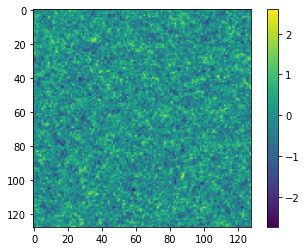

In [11]:
θ_target = np.array([0.7, 0.8])

rng, key = jax.random.split(rng)
δ_target = simulator(key, θ_target, simulator_args=simulator_args)
plt.imshow(δ_target)
plt.colorbar();

We can now define our prior distribution (in this case a uniform distribution over $A$ and $B$) with values between 0.1 and 1.25 for both parameters

In [12]:
prior = tfpj.distributions.Blockwise(
    [tfpj.distributions.Uniform(low=low, high=high)
     for low, high in zip([0.1, 0.1], [1.25, 1.25])])
prior.low = np.array([0.1, 0.1])
prior.high = np.array([1.25, 1.25])

To evaluate the likelihood of this field we can now use (dividing the target $\delta$ by $N$ to remove added scaling)

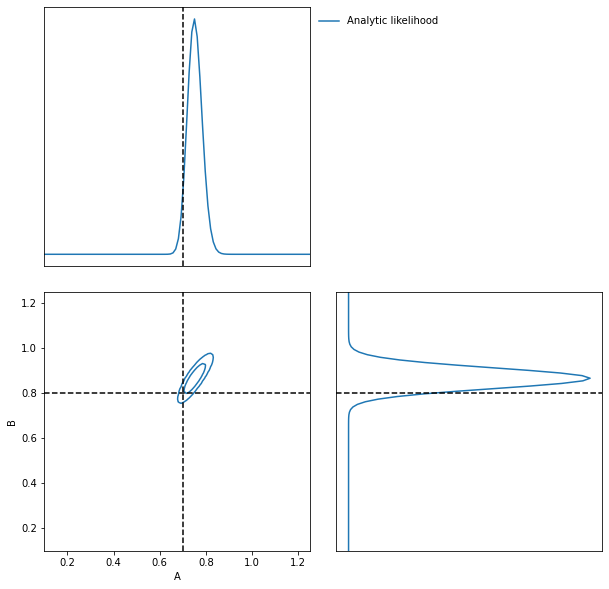

In [13]:
LFI = imnn.lfi.LikelihoodFreeInference(
    prior=prior,
    gridsize=100)
A, B = np.meshgrid(*LFI.ranges)
LFI.n_targets=1
LFI.put_marginals(
        jax.nn.softmax(
            np.real(
                log_likelihood(
                    k, 
                    A.ravel(), 
                    B.ravel(), 
                    np.fft.fftn(δ_target / N), 
                    N)
                ),axis=0
            ).reshape((100, 100)).T[np.newaxis]);
LFI.marginal_plot(
    known=θ_target,          
    label="Analytic likelihood",           
    axis_labels=["A", "B"]);

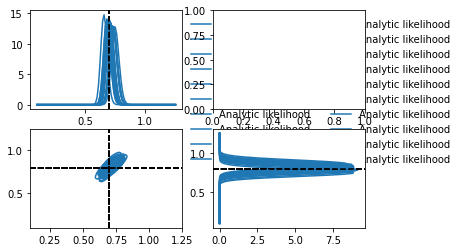

In [14]:
# sanity check:
fig,ax = plt.subplots(2,2)

for i in range(20):
    θ_target = np.array([0.7, 0.8])

    rng, key = jax.random.split(rng)
    δ_target = simulator(key, θ_target, simulator_args=simulator_args)


    LFI = imnn.lfi.LikelihoodFreeInference(
        prior=prior,
        gridsize=100)
    A, B = np.meshgrid(*LFI.ranges)
    LFI.n_targets=1
    LFI.put_marginals(
        jax.nn.softmax(
            np.real(
                log_likelihood(
                    k, 
                    A.ravel(), 
                    B.ravel(), 
                    np.fft.fftn(δ_target / N), 
                    N)
                ), axis=0).reshape((100, 100)).T[np.newaxis]);
    ax = LFI.marginal_plot(
        ax=ax,
        known=θ_target,          
        label="Analytic likelihood",           
        axis_labels=["A", "B"]);
    
plt.show()

## Training an IMNN

Now lets train an IMNN to summaries such Gaussian random fields to see how much information we can extract an what sort of constraints we can get. We will use 5000 simulations to estimate the covariance and use all of their derivatives and we'll summarise the whole random Gaussian field by 2 summaries.

In [15]:
n_s = 5000
n_d = n_s

n_summaries = 2

We're going to use a fully convolutional inception network built using stax with some custom designed blocks. The inception block itself is implemented as

In [16]:
def InceptBlock(filters, strides, do_5x5=True, do_3x3=True):
    """InceptNet convolutional striding block.
    filters: tuple: (f1,f2,f3)
    filters1: for conv1x1
    filters2: for conv1x1,conv3x3
    filters3L for conv1x1,conv5x5"""
    
    filters1, filters2, filters3 = filters
    conv1x1 = stax.serial(stax.Conv(filters1, (1, 1), strides, padding="SAME"))
    
    filters4 = filters2
    conv3x3 = stax.serial(stax.Conv(filters2, (1, 1), strides=None, padding="SAME"),
                        stax.Conv(filters4, (3, 3), strides, padding="SAME"))
                        
    filters5 = filters3
    conv5x5 = stax.serial(stax.Conv(filters3, (1, 1), strides=None, padding="SAME"),
                         stax.Conv(filters5, (5, 5), strides, padding="SAME")) 
    
    maxpool = stax.serial(stax.MaxPool((3, 3), padding="SAME"),
                         stax.Conv(filters4, (1, 1), strides, padding="SAME"))
                            
    if do_3x3:
        if do_5x5:
            return stax.serial(
                  stax.FanOut(4),
                  stax.parallel(conv1x1, conv3x3, conv5x5, maxpool),
                  stax.FanInConcat(), 
                  stax.LeakyRelu)
        else:
            return stax.serial(
                  stax.FanOut(3),
                  stax.parallel(conv1x1, conv3x3, maxpool),
                  stax.FanInConcat(), 
                  stax.LeakyRelu)
    else:
        return stax.serial(
              stax.FanOut(2),
              stax.parallel(conv1x1, maxpool),
              stax.FanInConcat(), 
              stax.LeakyRelu)

We'll also want to make sure that the output of the network is the correct shape, for which we'll introduce a Reshaping layer

In [17]:
def Reshape(shape):
    """Layer function for a reshape layer."""
    init_fun = lambda rng, input_shape: (shape,())
    apply_fun = lambda params, inputs, **kwargs: np.reshape(inputs, shape)
    return init_fun, apply_fun

Now we can build the network, with kernel sizes of 4 in each direction in each layer

In [18]:
fs = 84

model = stax.serial(
        InceptBlock((fs, fs, fs), strides=(4, 4)),
        InceptBlock((fs, fs, fs), strides=(4, 4)),
        InceptBlock((fs, fs, fs), strides=(4, 4)),
        InceptBlock((fs, fs, fs), strides=(2, 2), do_5x5=False, do_3x3=False),
        stax.Conv(n_summaries, (1, 1), strides=(1, 1), padding="SAME"),
        stax.Flatten,
        Reshape((n_summaries,)))

We'll also grab an adam optimiser from jax.experimental.optimizers

In [19]:
optimiser = optimizers.adam(step_size=1e-3)

Note that due to the form of the network we'll want to have simulations that have a "channel" dimension, which we can set up by not allowing for squeezing in the simulator.

### Initialise IMNN

Finally we can initialise the IMNN, letting the IMNN module decide what type of IMNN subclass will be used (we'll be using SimulatorIMNN)

In [20]:
rng, key = jax.random.split(rng)
IMNN = imnn.IMNN(
        n_s=n_s,
        n_d=n_d,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=(1, 1) + shape,
        θ_fid=θ_fid,
        model=model,
        optimiser=optimiser,
        key_or_state=key,
        simulator=lambda rng, θ: simulator(
            rng, θ, simulator_args={
                **simulator_args, 
                **{"squeeze": False}}))

`simulator` provided, using SimulatorIMNN


And finally we can fit the IMNN (we'll use generic regularisation parameters of $\lambda=10$ and $\epsilon=0.1$) and allow early stopping to determine the end of fitting.

In [24]:
%%time
rng, key = jax.random.split(rng)
IMNN.fit(λ=10., ϵ=0.1, rng=key, print_rate=None, min_iterations=1000, best=True)

CPU times: user 15min 35s, sys: 779 ms, total: 15min 35s
Wall time: 15min 32s


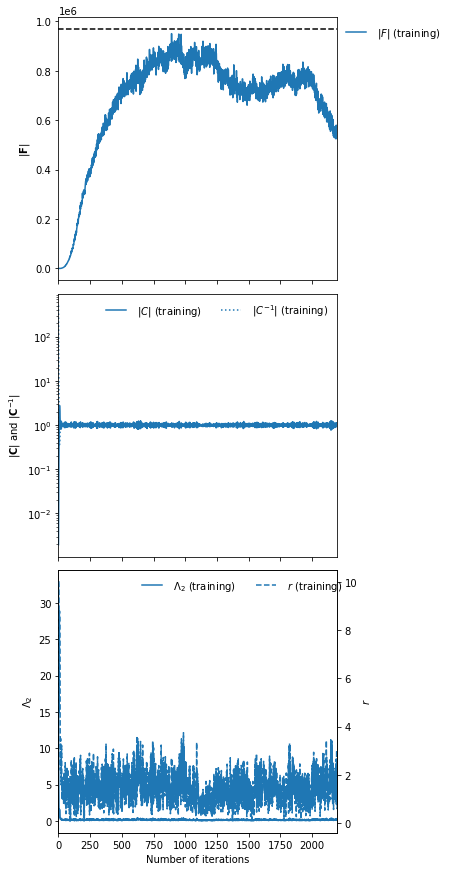

In [25]:
IMNN.plot(expected_detF=np.linalg.det(F));

In [26]:
np.linalg.det(IMNN.F) / np.linalg.det(F)

DeviceArray(0.91142211, dtype=float64)

In [27]:
np.linalg.det(F)

DeviceArray(967560.53213306, dtype=float64)

## Inference with Normalising Flows

We can now attempt to do inference of some target data using the IMNN. The first thing we should do is make a Gaussian approximation using a parameter estimate from the IMNN and the Fisher information reached at the end of fitting. Note that since the fiducial parameter values are far from the "target" that this estimate of the Fisher information as the covariance will likely be misleading.

We will then proceed to doing inference using a Conditional Autoregressive Flow.

In [28]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [29]:
import tensorflow_probability.substrates.jax as tfpj
tfdj = tfpj.distributions
tfbj = tfpj.bijectors

import tensorflow.keras.backend as K

In [30]:
from tqdm import trange
import numpy as onp

def affine_sample(log_prob, n_params, n_walkers, n_steps, walkers1, walkers2):
    
    # initialize current state
    current_state1 = tf.Variable(walkers1)
    current_state2 = tf.Variable(walkers2)
    

    # initial target log prob for the walkers (and set any nans to -inf)...
    logp_current1 = log_prob(current_state1)
    logp_current2 = log_prob(current_state2)
    logp_current1 = tf.where(tf.math.is_nan(logp_current1), tf.ones_like(logp_current1)*tf.math.log(0.), logp_current1)
    logp_current2 = tf.where(tf.math.is_nan(logp_current2), tf.ones_like(logp_current2)*tf.math.log(0.), logp_current2)

    # holder for the whole chain
    chain = [tf.concat([current_state1, current_state2], axis=0)]
    
    # MCMC loop
    with trange(1, n_steps) as t:
        for epoch in t:

            # first set of walkers:

            # proposals
            partners1 = tf.gather(current_state2, onp.random.randint(0, n_walkers, n_walkers))
            z1 = 0.5*(tf.random.uniform([n_walkers], minval=0, maxval=1)+1)**2
            proposed_state1 = partners1 + tf.transpose(z1*tf.transpose(current_state1 - partners1))
            

            # target log prob at proposed points
            logp_proposed1 = log_prob(proposed_state1)
            logp_proposed1 = tf.where(tf.math.is_nan(logp_proposed1), tf.ones_like(logp_proposed1)*tf.math.log(0.), logp_proposed1)

            # acceptance probability
            p_accept1 = tf.math.minimum(tf.ones(n_walkers), z1**(n_params-1)*tf.exp(logp_proposed1 - logp_current1) )

            # accept or not
            accept1_ = (tf.random.uniform([n_walkers], minval=0, maxval=1) <= p_accept1)
            accept1 = tf.cast(accept1_, tf.float32)

            # update the state
            current_state1 = tf.transpose( tf.transpose(current_state1)*(1-accept1) + tf.transpose(proposed_state1)*accept1)
            logp_current1 = tf.where(accept1_, logp_proposed1, logp_current1)

            # second set of walkers:

            # proposals
            partners2 = tf.gather(current_state1, onp.random.randint(0, n_walkers, n_walkers))
            z2 = 0.5*(tf.random.uniform([n_walkers], minval=0, maxval=1)+1)**2
            proposed_state2 = partners2 + tf.transpose(z2*tf.transpose(current_state2 - partners2))

            # target log prob at proposed points
            logp_proposed2 = log_prob(proposed_state2)
            logp_proposed2 = tf.where(tf.math.is_nan(logp_proposed2), tf.ones_like(logp_proposed2)*tf.math.log(0.), logp_proposed2)

            # acceptance probability
            p_accept2 = tf.math.minimum(tf.ones(n_walkers), z2**(n_params-1)*tf.exp(logp_proposed2 - logp_current2) )

            # accept or not
            accept2_ = (tf.random.uniform([n_walkers], minval=0, maxval=1) <= p_accept2)
            accept2 = tf.cast(accept2_, tf.float32)

            # update the state
            current_state2 = tf.transpose( tf.transpose(current_state2)*(1-accept2) + tf.transpose(proposed_state2)*accept2)
            logp_current2 = tf.where(accept2_, logp_proposed2, logp_current2)

            # append to chain
            chain.append(tf.concat([current_state1, current_state2], axis=0))

    # stack up the chain
    chain = tf.stack(chain, axis=0)
    
    return chain


In [140]:
class ConditionalMaskedAutoregressiveFlow(tf.Module):
    def __init__(self, n_dimensions=None, n_conditionals=None, n_mades=1, n_hidden=[50,50], input_order="random",
    activation=tf.keras.layers.LeakyReLU(0.01), 
    all_layers=True,
    kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1e-5, seed=None), 
    bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1e-5, seed=None),
    kernel_regularizer=None, bias_regularizer=None, kernel_constraint=None,
    bias_constraint=None):
        super(ConditionalMaskedAutoregressiveFlow, self).__init__()
        # extract init parameters
        self.n_dimensions = n_dimensions
        self.n_conditionals = n_conditionals
        self.n_mades = n_mades
        # construct the base (normal) distribution
        self.base_distribution = tfd.MultivariateNormalDiag(loc=tf.zeros(self.n_dimensions), scale_diag=tf.ones(self.n_dimensions))
        # put the conditional inputs to all layers, or just the first layer?
        if all_layers == True:
            all_layers = "all_layers"
        else:
            all_layers = "first_layer"
        # construct stack of conditional MADEs
        self.MADEs = [tfb.AutoregressiveNetwork(
                        params=2,
                        hidden_units=n_hidden,
                        activation=activation,
                        event_shape=[n_dimensions],
                        conditional=True,
                        conditional_event_shape=[n_conditionals],
                        conditional_input_layers=all_layers,
                        input_order=input_order,
                        kernel_initializer=kernel_initializer,
                        bias_initializer=bias_initializer,
                        kernel_regularizer=kernel_regularizer,
                        bias_regularizer=bias_regularizer,
                        kernel_constraint=kernel_constraint,
                        bias_constraint=bias_constraint,
                        name="MADE_{}".format(i)) for i in range(n_mades)]
    # bijector for x | y (chain the conditional MADEs together)
    def bijector(self, y):
        # start with an empty bijector
        MAF = tfb.Identity() 
        # pass through the MADE layers (passing conditional inputs each time)
        for i in range(self.n_mades):
            MAF = tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=lambda x: self.MADEs[i](x, conditional_input=y))(MAF)
        return MAF
    # construct distribution P(x | y)
    def __call__(self, y):
        return tfd.TransformedDistribution(
            self.base_distribution,
            bijector=self.bijector(y))
    # log probability ln P(x | y)
    def log_prob(self, x, y):
        return self.__call__(y).log_prob(x)
    # sample n samples from P(x | y)
    def sample(self, n, y):
        # base samples
        base_samples = self.base_distribution.sample(n)
        # biject the samples
        return self.bijector(y).forward(base_samples)

In [159]:
num_models = 2
cmaf_models = [ConditionalMaskedAutoregressiveFlow(n_dimensions=2, 
                                                   n_conditionals=2, n_hidden=[50,50,50]) for i in range(num_models)]

cmaf_models += [ConditionalMaskedAutoregressiveFlow(n_dimensions=2, 
                                                    n_conditionals=2, n_hidden=[50,50]) for i in range(2)]

In [160]:
maf_optimizers = [tf.keras.optimizers.Adam(learning_rate=1e-3) for i in range(len(cmaf_models))]

In [161]:
# prior for sim draws in jax
prior = tfpj.distributions.Blockwise(
    [tfpj.distributions.Uniform(low=low, high=high)
     for low, high in zip([0.4, 0.4], [1.0, 1.1])])
prior.low = np.array([0.4, 0.4])
prior.high = np.array([1.0, 1.1])



# set up prior in non-jax tfp
samp_prior = tfp.distributions.Blockwise(
    [tfp.distributions.Uniform(low=low, high=high)
     for low, high in zip([0.4, 0.4], [1.0, 1.1])])
prior.low = np.array([0.4, 0.4])
prior.high = np.array([1.0, 1.1])

@tf.function
def train_step(x, y):
    _ls = []
    for m in range(len(cmaf_models)):
        with tf.GradientTape() as tape:
            _l = K.mean(-cmaf_models[m].log_prob(x, y) - samp_prior.log_prob(y))
            _ls.append(_l)
        
        grads = tape.gradient(_l, cmaf_models[m].trainable_variables)
        maf_optimizers[m].apply_gradients(zip(grads, cmaf_models[m].trainable_variables))
        #train_acc_metric.update_state(y, logits)
    return _ls

@tf.function
def val_step(x, y):
    _val_l = []
    for m in range(len(cmaf_models)):
        _val_l.append(K.mean(-cmaf_models[m].log_prob(x, y) - samp_prior.log_prob(y)))
    return _val_l

@tf.function
def loss(x, y):
    return K.mean(-cmaf_model.log_prob(x, y))

In [162]:
from sklearn.preprocessing import StandardScaler
summary_scaler = StandardScaler()

In [163]:
# create dataset for this demo

num_sims = 1000

keys = jax.random.split(rng, num=num_sims)

def get_params_summaries(key, n_samples, ϑ_samp):
    keys = np.array(jax.random.split(key, num=n_samples))
    sim = lambda rng, θ: simulator(
            rng, θ, simulator_args={
                **simulator_args, 
                **{"squeeze": False}})
    d = jax.vmap(sim)(keys, ϑ_samp)
    
    t = IMNN.get_estimate(d)
    
    t1 = t.flatten()[~np.isnan(t.flatten())]
    ϑ_samp = ϑ_samp.flatten()[~np.isnan(t.flatten())]
    
    # scale all summaries
    t1 = t1.reshape((len(t1)//2, 2))
    
    #_tstd = np.std(t1, axis=0)
    #_tmu = np.mean(t1, axis=0)
    
    #t1 = (t1 - _tmu) / _tstd
    
    # return x,y; e.g. t and ϑ (conditional)
    # learn p(x | y) = p(t | ϑ)
    return t1, ϑ_samp.reshape(len(ϑ_samp)//2, 2) #, _tmu, _tstd


def get_dataset(data, batch_size=20, buffer_size=1000, split=0.75):
    x,y = data

    # shufle data right off the bat
#     shuffle_idx = onp.random.choice(np.arange(len(x)), size=len(x))
#     x = x[shuffle_idx]
#     y = y[shuffle_idx]
    
    idx = int(len(x)*split)
    x_train = x[:idx]
    y_train = y[:idx]  
    x_val = x[idx:]
    y_val = y[idx:]

    # Prepare the training dataset.
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=buffer_size).batch(batch_size)

    # Prepare the validation dataset.
    val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    val_dataset = val_dataset.batch(batch_size)
    
    return train_dataset, val_dataset

def proposal_distribution(prior, MAF):
    """return geometric mean of proposal distribution"""
    
    
    

In [164]:
n_samples = 1000
batch_size = 100
buffer_size = n_samples
key1,key2 = jax.random.split(rng)

ϑ_samp = prior.sample(sample_shape=(n_samples,), seed=key1)
ts, ϑ_samp = get_params_summaries(key2, n_samples, ϑ_samp)
data = (ts, ϑ_samp)

In [165]:
train_dataset, val_dataset = get_dataset(data, batch_size=batch_size, buffer_size=buffer_size)

In [166]:
import time
from tqdm import tqdm

epochs = 2000

train_losses = []
val_losses = []


for epoch in tqdm(range(epochs)):
    #print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()


#     ϑ_samp = prior.sample(sample_shape=(n_samples,), seed=key)
#     data = get_params_summaries(key, n_samples, ϑ_samp)
#    train_dataset, val_dataset = get_dataset(data, batch_size=100)

    # shuffle training data anew every 100th epoch
    if epoch % 100 == 0:
        train_dataset = train_dataset.shuffle(buffer_size=buffer_size)


    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        loss_values = np.array(train_step(x_batch_train, y_batch_train))

    train_losses.append(loss_values)


    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        val_loss = np.array(val_step(x_batch_val, y_batch_val))

    val_losses.append(val_loss)

100%|██████████| 2000/2000 [01:02<00:00, 32.16it/s]


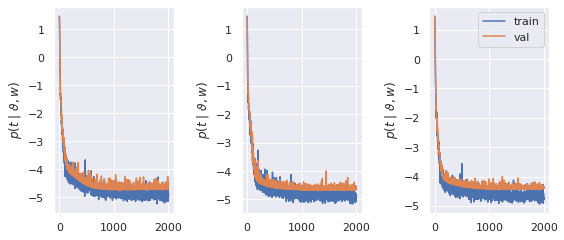

In [167]:
import seaborn as sns
%matplotlib inline

sns.set_theme()
plt.figure(figsize=(8,3.5))
plt.subplot(131)
plt.plot(np.array(train_losses).T[0], label='train')
plt.plot(np.array(val_losses).T[0], label='val')
plt.ylabel(r'$p(t\ |\ \vartheta, w)$')

plt.subplot(132)
plt.plot(np.array(train_losses).T[1], label='train')
plt.plot(np.array(val_losses).T[1], label='val')
plt.ylabel(r'$p(t\ |\ \vartheta, w)$')

plt.subplot(133)
plt.plot(np.array(train_losses).T[4], label='train')
plt.plot(np.array(val_losses).T[4], label='val')
plt.ylabel(r'$p(t\ |\ \vartheta, w)$')
plt.legend()

plt.tight_layout()
plt.show()

100%|██████████| 1999/1999 [00:06<00:00, 295.44it/s]


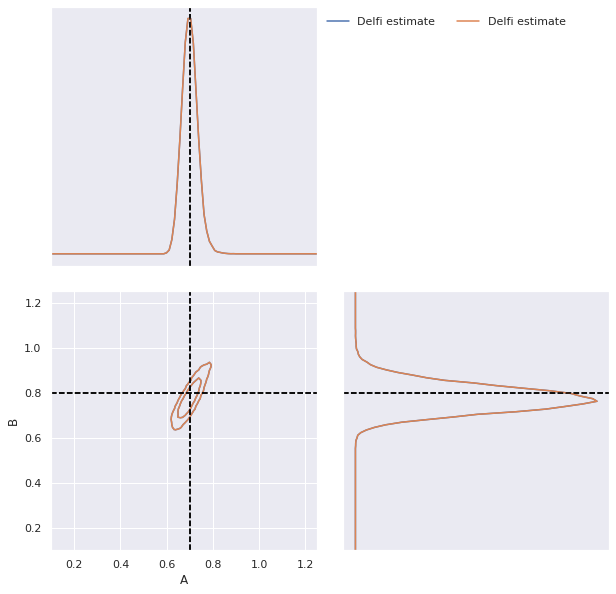

In [168]:
# get summaries for observed data from IMNN
# δ_target is the 128x128 simulation
estimates = IMNN.get_estimate(np.expand_dims(δ_target, (0, 1, 2)))

#_estimates = (estimates - tmu) / tstd


# set up prior in non-jax tfp
samp_prior = tfp.distributions.Blockwise(
    [tfp.distributions.Uniform(low=low, high=high)
     for low, high in zip([0.1, 0.1], [1.25, 1.25])])
prior.low = np.array([0.1, 0.1])
prior.high = np.array([1.25, 1.25])

# define cmaf model log prob with prior defined above
@tf.function
def my_log_prob(y, x=estimates):
    
    # here all cmafs are trained to draw from p(x|y) <=> p(t|ϑ)
    # take the mean of the data likelihood p(x|y) over all cmafs
    _like = cmaf_models[0].log_prob(x,y)

    _prior = samp_prior.log_prob(x)
    
    return _like + _prior



# sample using affine
n_steps = 2000
n_walkers = 500
burnin_steps = 1800
n_params = 2

# initialize walkers...
walkers1 = tf.random.normal([n_walkers, 2], 0.5, 0.5)
walkers2 = tf.random.normal([n_walkers, 2], 0.5, 0.5)

# walkers1 = tf.random.uniform([n_walkers, 2], 0.1, 1.25)
# walkers2 = tf.random.uniform([n_walkers, 2], 0.1, 1.25)

chain = affine_sample(my_log_prob, n_params, n_walkers, n_steps, walkers1, walkers2)

skip = 4

post = np.stack([chain.numpy()[burnin_steps::skip,:,0].flatten(), chain.numpy()[burnin_steps::skip,:,1].flatten()], axis=-1)

# make ABC object for the marginal plot
_ABC = imnn.lfi.ApproximateBayesianComputation(
    target_data=np.expand_dims(δ_target, (0, 1, 2)),
    prior=prior,
    simulator=lambda rng, θ: simulator(rng, θ, simulator_args={**simulator_args, **{'squeeze':False}}),
    compressor=IMNN.get_estimate,
    gridsize=100, 
    F=np.expand_dims(IMNN.F, 0))

margs = _ABC.get_marginals(accepted_parameters = [np.array(post)], smoothing=None, gridsize=400)


MAF = imnn.lfi.LikelihoodFreeInference(
    prior=prior,
    gridsize=100)


MAF.n_targets=2
MAF.put_marginals(
                margs[1][0]);

MAF.marginal_plot(
    known=θ_target,          
    label="Delfi estimate",           
    axis_labels=["A", "B"]);

# next sample from the new posterior and re-train:

In [170]:
n_samples = 1000
key1,key2 = jax.random.split(rng)

idx = np.arange(len(post))
ϑ_samp = post[45000:][onp.random.choice(idx, size=n_samples)]

# ensure not < 0
idx = np.where(ϑ_samp > 0)[0]
ϑ_samp = ϑ_samp[idx]
n_samples = len(ϑ_samp)

ts, ϑ_samp = get_params_summaries(key2, n_samples, ϑ_samp)

new_data = (ts, ϑ_samp)

# this should shuffle the dataset 
new_train_dataset, new_val_dataset = get_dataset(new_data, batch_size=batch_size, buffer_size=len(new_data[0]))

# concatenate datasets
train_dataset = train_dataset.concatenate(new_train_dataset)
#val_dataset = val_dataset.concatenate(new_val_dataset)

In [184]:
epochs = 1000

new_train_losses = []
new_val_losses = []


for epoch in tqdm(range(epochs)):
    #print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()

    # generate data anew each epoch
#     ϑ_samp = prior.sample(sample_shape=(n_samples,), seed=key)
#     data = get_params_summaries(key, n_samples, ϑ_samp)
#     train_dataset, val_dataset = get_dataset(data, batch_size=100)

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        loss_values = np.array(train_step(x_batch_train, y_batch_train))

    new_train_losses.append(loss_values)


    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        val_loss = np.array(val_step(x_batch_val, y_batch_val))

    new_val_losses.append(val_loss)

100%|██████████| 1000/1000 [01:01<00:00, 16.16it/s]


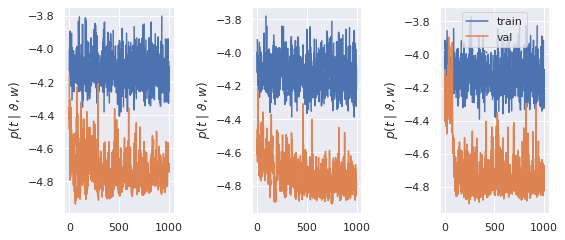

In [185]:
plt.figure(figsize=(8,3.5))
plt.subplot(131)
plt.plot(np.array(new_train_losses).T[0], label='train')
plt.plot(np.array(new_val_losses).T[0], label='val')
plt.ylabel(r'$p(t\ |\ \vartheta, w)$')

plt.subplot(132)
plt.plot(np.array(new_train_losses).T[1], label='train')
plt.plot(np.array(new_val_losses).T[1], label='val')
plt.ylabel(r'$p(t\ |\ \vartheta, w)$')

plt.subplot(133)
plt.plot(np.array(new_train_losses).T[4], label='train')
plt.plot(np.array(new_val_losses).T[4], label='val')
plt.ylabel(r'$p(t\ |\ \vartheta, w)$')
plt.legend()

plt.tight_layout()
plt.show()

100%|██████████| 1999/1999 [00:06<00:00, 316.72it/s]


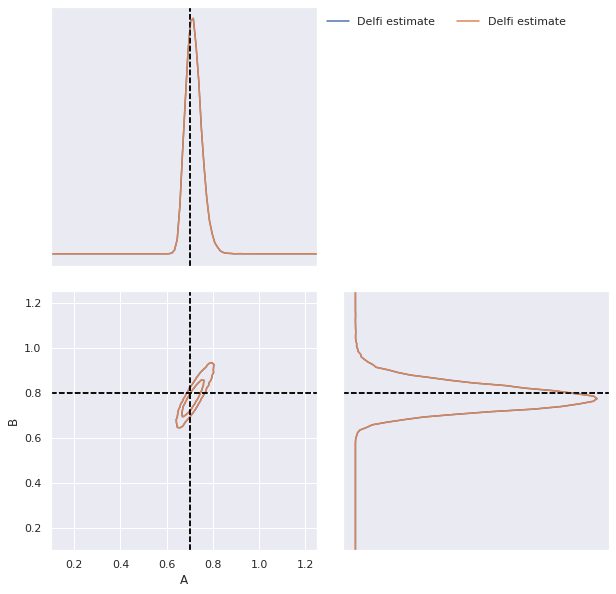

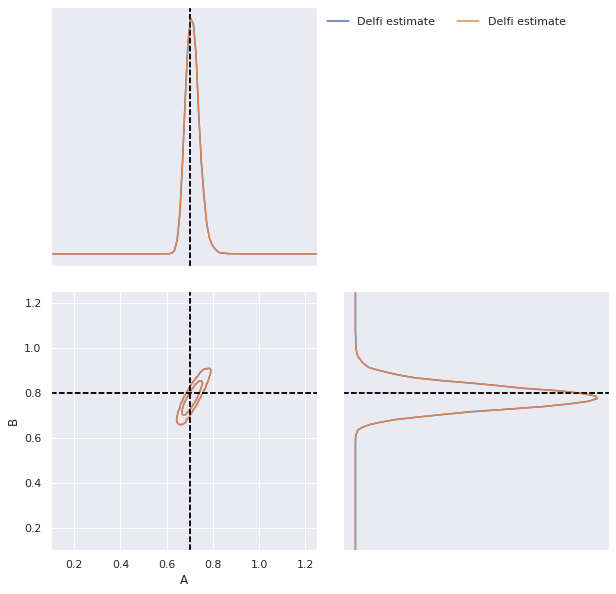

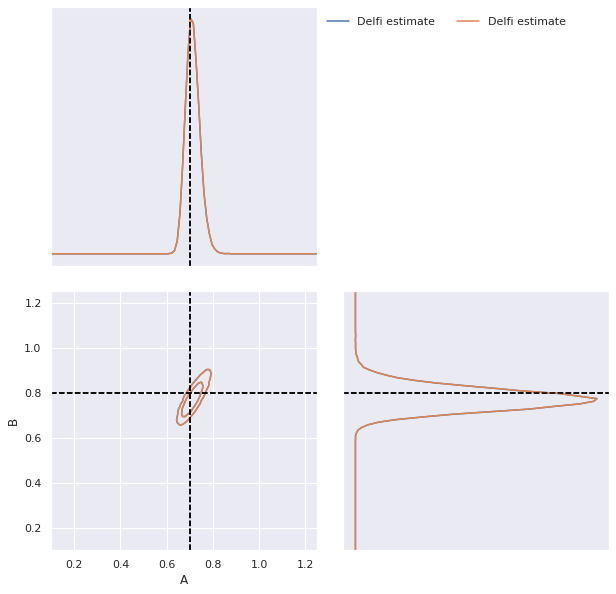

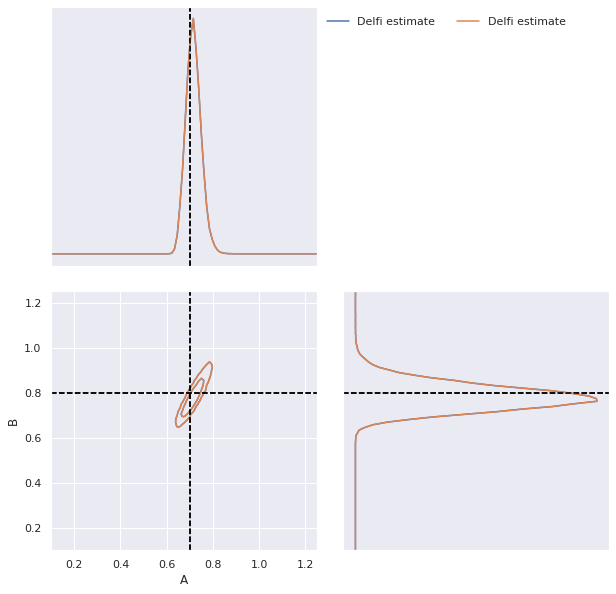

In [186]:
# get summaries for observed data from IMNN
# δ_target is the 128x128 simulation


# do for each model
MAFs = []

for m,cmaf_model in enumerate(cmaf_models):

    @tf.function
    def my_log_prob(y, x=estimates):

        # here all cmafs are trained to draw from p(x|y) <=> p(t|ϑ)
        # take the mean of the data likelihood p(x|y) over all cmafs
        _like = cmaf_models[m].log_prob(x,y)
        _prior = samp_prior.log_prob(y)

        return _like + _prior

    # sample using affine
    n_steps = 2000
    n_walkers = 500
    burnin_steps = 1800
    n_params = 2

    # initialize walkers...
    walkers1 = tf.random.normal([n_walkers, 2], 0.5, 0.5)
    walkers2 = tf.random.normal([n_walkers, 2], 0.5, 0.5)

    # walkers1 = tf.random.uniform([n_walkers, 2], 0.1, 1.25)
    # walkers2 = tf.random.uniform([n_walkers, 2], 0.1, 1.25)

    chain = affine_sample(my_log_prob, n_params, n_walkers, n_steps, walkers1, walkers2)

    skip = 4

    post = np.stack([chain.numpy()[burnin_steps::skip,:,0].flatten(), chain.numpy()[burnin_steps::skip,:,1].flatten()], axis=-1)

    margs = ABC.get_marginals(accepted_parameters = [np.array(post)], smoothing=None, gridsize=400)


    _MAF = imnn.lfi.LikelihoodFreeInference(
        prior=prior,
        gridsize=100)


    _MAF.n_targets=2
    _MAF.put_marginals(
                    margs[1][0]);
    
    MAFs.append(_MAF)

    _MAF.marginal_plot(
        known=θ_target,          
        label="Delfi estimate",           
        axis_labels=["A", "B"]);

In [578]:
post = np.stack([chain.numpy()[burnin_steps:,:,0].flatten(), chain.numpy()[burnin_steps:,:,1].flatten()], axis=-1)

In [532]:
post.shape

(600000, 2)

# now get the MAF's posterior estimate

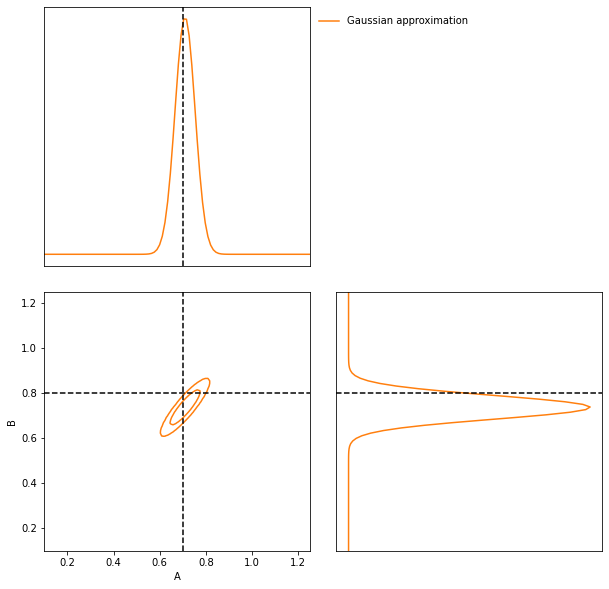

In [34]:
GA = imnn.lfi.GaussianApproximation(
    parameter_estimates=IMNN.get_estimate(np.expand_dims(δ_target, (0, 1, 2))), 
    invF=np.expand_dims(np.linalg.inv(IMNN.F), 0), 
    prior=prior, 
    gridsize=100)
GA.marginal_plot(
    known=θ_target,          
    label="Gaussian approximation",           
    axis_labels=["A", "B"],
    colours="C1");

And finally we can do an approximate Bayesian computation

In [35]:
ABC = imnn.lfi.ApproximateBayesianComputation(
    target_data=np.expand_dims(δ_target, (0, 1, 2)),
    prior=prior,
    simulator=lambda rng, θ: simulator(rng, θ, simulator_args={**simulator_args, **{'squeeze':False}}),
    compressor=IMNN.get_estimate,
    gridsize=100, 
    F=np.expand_dims(IMNN.F, 0))

In [36]:
rng, key = jax.random.split(rng)
ABC(ϵ=1., rng=key, n_samples=10000, min_accepted=2000, 
    smoothing=1, max_iterations=2000);

[2019] accepted in last  87 iterations  (870000 simulations done).


In [37]:
ABC.parameters.accepted[0].shape

(2019, 2)

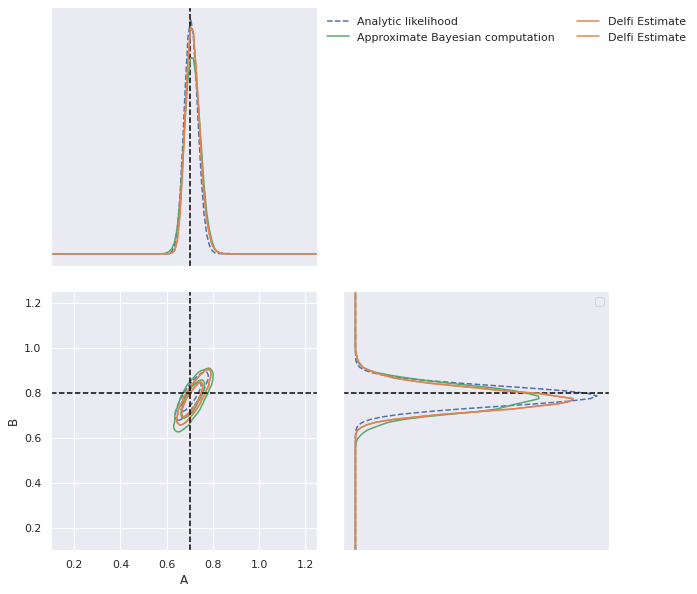

In [196]:
ax = LFI.marginal_plot(
    known=θ_target,          
    label="Analytic likelihood",           
    axis_labels=["A", "B"],
    linestyle='--')


# GA.marginal_plot(
#     ax=ax,
#     label="Gaussian approximation",
#     colours="C4", 
#     axis_labels=["A", "B"])


ABC.marginal_plot(
    ax=ax,
    label="Approximate Bayesian computation",
    colours="C2");


for m,_MAF in enumerate(MAFs[2:3]):
    if m == 0:
        label = 'Delfi Estimate'
    else:
        label=None
        
    _MAF.marginal_plot(
        ax=ax,
        label=label,
        colours="C1", linestyle='solid');

    
plt.savefig('/mnt/home/tmakinen/repositories/field-plots/gauss_delfi_vs_abc.png', dpi=800)
plt.legend()
plt.show()


# Cosmological parameter inference of log normal fields

As a more realistic example of cosmological parameter inference from dark matter fields, albeit it one where we do not (yet) know the amount of information in the field, we can create a log normal field from a power spectrum generated with cosmological parameters.

For example lets say that our fiducial cosmology has $\Omega_c=0.40$ and $\sigma_8=0.75$, we can set

In [23]:
cosmo_params = jc.Planck15(Omega_c=0.40, sigma8=0.75)
θ_fid = np.array(
    [cosmo_params.Omega_c, 
     cosmo_params.sigma8], 
    dtype=np.float32)

Our new $P(k)$ is simply the linear matter power spectrum defined as

In [24]:
def P(k, A=0.40, B=0.75):
    cosmo_params = jc.Planck15(Omega_c=A, sigma8=B)
    return jc.power.linear_matter_power(cosmo_params, k)

In [25]:
simulator_args = dict(
    k=k,
    L=250,
    shape=shape,
    vol_norm=True,
    N_scale=False,
    squeeze=True,
    log_normal=True)

Since our lognormal field simulator *and* power spectra code are differentiable via `Jax`, we can simulate a *differentiable* universe. We'll pull out a nice function to visualize fiducial example data and its derivatives with respect to the cosmological parameters.

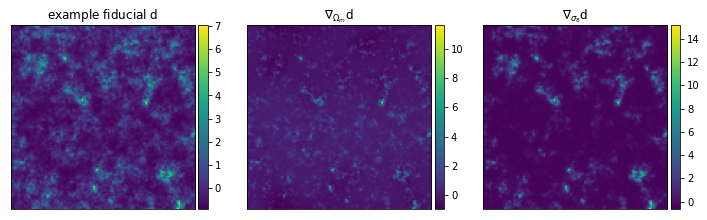

In [26]:
from imnn.utils import value_and_jacrev, value_and_jacfwd

def simulator_gradient(rng, θ, simulator_args=simulator_args):
    return value_and_jacrev(simulator, argnums=1, allow_int=True, holomorphic=True)(rng, θ, simulator_args=simulator_args)

simulation, simulation_gradient = value_and_jacfwd(simulator, argnums=1)(rng, θ_fid, 
                                                        simulator_args=simulator_args)

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig,ax = plt.subplots(nrows=1, ncols=3, figsize=(12,15))

im1 = ax[0].imshow(np.squeeze(simulation), extent=(0,1,0,1))
ax[0].title.set_text(r'example fiducial $\rm d$')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

im1 = ax[1].imshow(np.squeeze(simulation_gradient).T[0].T, extent=(0,1,0,1))
ax[1].title.set_text(r'$\nabla_{\Omega_m} \rm d$')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

im1 = ax[2].imshow(np.squeeze(simulation_gradient).T[1].T, extent=(0,1,0,1))
ax[2].title.set_text(r'$\nabla_{\sigma_8} \rm d$')
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

for a in ax:
    a.set_xticks([])
    a.set_yticks([])
    
plt.show()

We'll now make the target universe that we observe a little more realistic with $\Omega_c=0.35$ and $\sigma_8=0.8$

In [ ]:
θ_target = np.array([0.35, 0.8])

rng, key = jax.random.split(rng)
δ_target = simulator(
    key, θ_target, simulator_args=simulator_args, 
)
plt.imshow(δ_target)
plt.colorbar();

We can now train an IMNN as before

In [28]:
rng, key = jax.random.split(rng)
IMNN = imnn.IMNN(
        n_s=n_s,
        n_d=n_d,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=(1, 1) + shape,
        θ_fid=θ_fid,
        model=model,
        optimiser=optimiser,
        key_or_state=key,
        simulator=lambda rng, θ: simulator(
            rng, θ, simulator_args={**simulator_args, **{"squeeze": False}}))

`simulator` provided, using SimulatorIMNN


In [30]:
βe
rng, key = jax.random.split(rng)
IMNN.fit(λ=10., ϵ=0.1, rng=key, print_rate=None, min_iterations=500, best=False)

CPU times: user 19min 21s, sys: 3min 38s, total: 23min
Wall time: 23min 6s


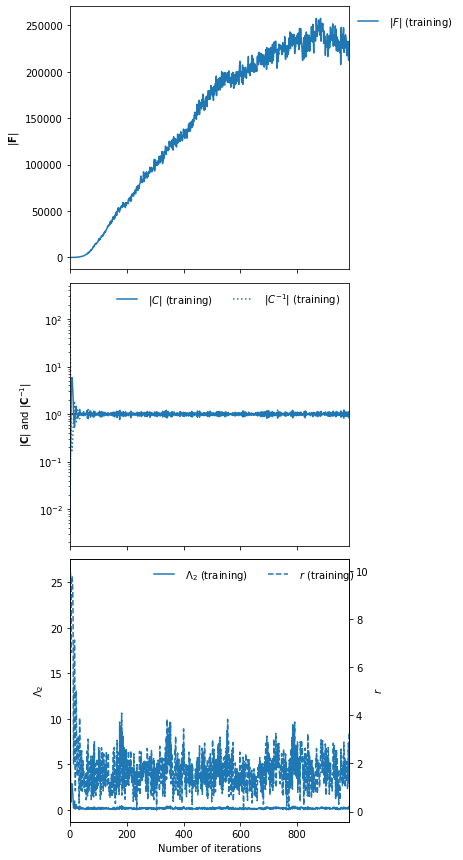

In [31]:
IMNN.plot(expected_detF=None);

And finally we can do our inference. We'll first set the prior distribution

In [35]:
prior = tfp.distributions.Blockwise(
    [tfp.distributions.Uniform(low=low, high=high)
     for low, high in zip([0., 0.], [1.5, 1.5])])
prior.low = np.array([0., 0.])
prior.high = np.array([1.5, 1.5])

And make the Gaussian approximation using the Fisher information

In [36]:
GA = imnn.lfi.GaussianApproximation(
    parameter_estimates=IMNN.get_estimate(np.expand_dims(δ_target, (0, 1, 2))), 
    invF=np.expand_dims(np.linalg.inv(IMNN.F), 0), 
    prior=prior, 
    gridsize=100)

And then run the ABC

In [37]:
ABC = imnn.lfi.ApproximateBayesianComputation(
    target_data=np.expand_dims(δ_target, (0, 1, 2)),
    prior=prior,
    simulator=lambda rng, θ: simulator(rng, θ, simulator_args={**simulator_args, **{'squeeze':False}}),
    compressor=IMNN.get_estimate,
    gridsize=100, 
    F=np.expand_dims(IMNN.F, 0))

In [61]:
%%time
rng, key = jax.random.split(rng)
ABC(ϵ=0.1, rng=key, n_samples=10000, min_accepted=5000, 
    smoothing=1., max_iterations=5000);

KeyboardInterrupt: 

And then we can plot the constraints obtained using the IMNN and LFI

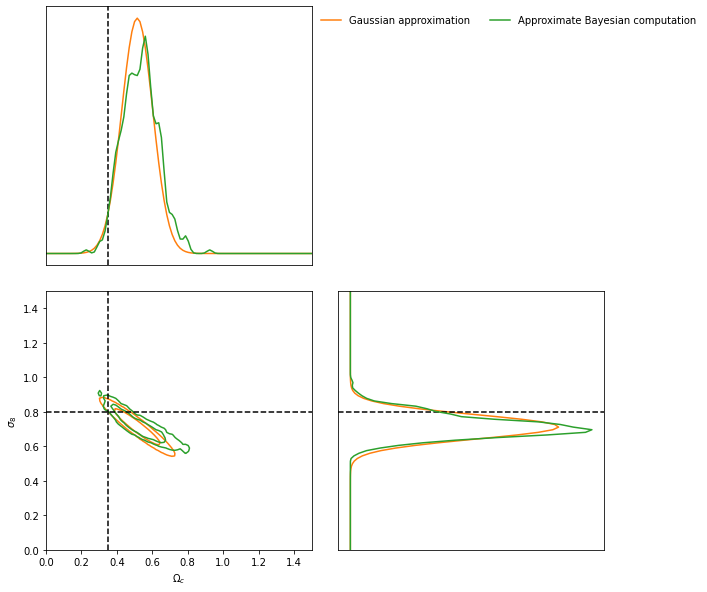

In [62]:
ax = GA.marginal_plot(
    known=θ_target,          
    label="Gaussian approximation",         
    axis_labels=[r"$\Omega_c$", r"$\sigma_8$"],
    colours="C1")
ABC.marginal_plot(
    ax=ax,
    label="Approximate Bayesian computation",
    colours="C2");